Notebook by Zara

### **Faster R-CNN**

In [2]:
import pandas as pd
import numpy as np
import os
import cv2

In [3]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import FasterRCNN
import torch.optim as optim
from tqdm import tqdm

In [4]:
data = pd.read_csv('/Users/zaravanthoff/Desktop/MasterProject/Datasets/PublicDataset/flickr_logos_27_dataset/flickr_logos_27_dataset_training_set_annotation.txt', sep='\s+',header=None)
# Rename the columns
data.columns = ['Image', 'Class', 'Label', 'Xmin', 'Ymin', 'Xmax', 'Ymax']

folder_path = "/Users/zaravanthoff/Desktop/MasterProject/Datasets/PublicDataset/flickr_logos_27_dataset/flickr_logos_27_dataset_images"


In [5]:
data

,Image,Class,Label,Xmin,Ymin,Xmax,Ymax
0,144503924.jpg,Adidas,1,38,12,234,142
1,2451569770.jpg,Adidas,1,242,208,413,331
2,390321909.jpg,Adidas,1,13,5,89,60
3,4761260517.jpg,Adidas,1,43,122,358,354
4,4763210295.jpg,Adidas,1,83,63,130,93
...,...,...,...,...,...,...,...
4531,2126991906.jpg,Yahoo,6,15,6,253,54
4532,217288720.jpg,Yahoo,6,136,161,304,222
4533,2472817996.jpg,Yahoo,6,2,4,499,106
4534,2514220918.jpg,Yahoo,6,1,69,342,157


``Preprocessing``

Here's what this function does:

- Image Loading: It loads images using OpenCV (cv2.imread) and converts them to RGB format (cv2.cvtColor(image, cv2.COLOR_BGR2RGB)). This step ensures that the images are in the correct format for further processing.
- Label Extraction: It extracts bounding box coordinates and class labels from the dataset. This information is necessary for training an object detection model like Faster R-CNN.
- Error Handling: It handles exceptions that might occur during image loading. This is important for robustness, especially when dealing with a large number of images.

In [6]:
def load_images_and_labels(data, folder_path):
    images = []
    labels = []
    failed_images = []

    for index, row in data.iterrows():
        # Print the key for debugging
        print("Key:", index)

        try:
            # Extract image filename from the dataset
            image_filename = row[0]  # Assuming the column name is 'Image'
            print("Image Filename:", image_filename)

            # Construct the full path to the image
            image_path = os.path.join(folder_path, image_filename)
            print("Image Path:", image_path)  # Print out the image path

            # Load and preprocess the image
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Check if the image was loaded successfully
            if image is not None:
                images.append(image)

                # Extract bounding box coordinates and class label
                xmin = row['Xmin']
                ymin = row['Ymin']
                xmax = row['Xmax']
                ymax = row['Ymax']
                class_label = row['Label']
                label = [class_label, xmin, ymin, xmax, ymax]
                labels.append(label)

                # Print the label for debugging
                print("Label:", label)
            else:
                print(f"Failed to load image: {image_path}")
                failed_images.append(image_path)
        except Exception as e:
            print(f"Failed to load image: {image_path}, Error: {e}")
            failed_images.append(image_path)

    return images, labels, failed_images

In [7]:
# # Call the load_images_and_labels function
# images, labels, failed_images = load_images_and_labels(data, folder_path)

``Data Visualization`` 

Visualize a few samples from your dataset along with their labels to ensure that the data loading and preprocessing steps are performed correctly.

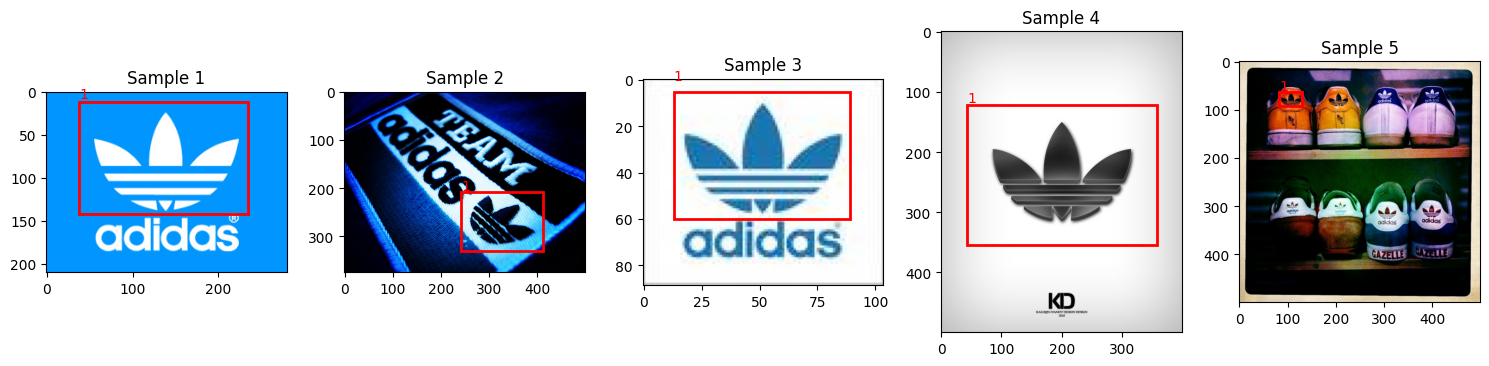

In [8]:
import matplotlib.pyplot as plt
import cv2

def visualize_samples(data, folder_path, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    for i, (index, row) in enumerate(data.iterrows()):
        if i >= num_samples:
            break
        
        image_filename = row['Image']  # Assuming the column name is 'Image'
        image_path = os.path.join(folder_path, image_filename)
        
        # Load and plot the image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[i].imshow(image)
        axes[i].set_title(f"Sample {i + 1}")

        # Plot bounding boxes
        xmin = row['Xmin']
        ymin = row['Ymin']
        xmax = row['Xmax']
        ymax = row['Ymax']
        class_label = row['Label']
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             edgecolor='r', facecolor='none', linewidth=2)
        axes[i].add_patch(rect)
        axes[i].text(xmin, ymin - 5, class_label, color='r')

    plt.tight_layout()
    plt.show()

# Visualize 5 samples from the dataset
visualize_samples(data, folder_path, num_samples=5)


``Data splitting``

In [9]:
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from custom_dataset import CustomDataset  # Assuming CustomDataset is defined in custom_dataset.py

# Split data into training, validation, and test sets
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Optionally, reset the index of the dataframes
train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor()
])

# Create custom datasets
train_dataset = CustomDataset(train_data, folder_path, transform=transform)
val_dataset = CustomDataset(val_data, folder_path, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)


In [10]:
# from sklearn.model_selection import train_test_split

# # Assuming 'data' is your dataset
# # Split data into training (70%) and temporary (30%) sets
# train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)

# # Split the temporary data into validation (15%) and test (15%) sets
# val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# # Optionally, you can reset the index of the dataframes if needed
# train_data.reset_index(drop=True, inplace=True)
# val_data.reset_index(drop=True, inplace=True)
# test_data.reset_index(drop=True, inplace=True)

In [11]:
# from custom_dataset import CustomDataset

# # Define transformations
# transform = transforms.Compose([transforms.Resize((224, 224)),  # Example transformations
#                                 transforms.ToTensor()])

# # Create custom datasets
# train_dataset = CustomDataset(train_data, folder_path, transform=transform)
# val_dataset = CustomDataset(val_data, folder_path, transform=transform)

# # Now create your data loader
# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
# val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)

In [12]:
# import torchvision.transforms as transforms
# from torch.utils.data import DataLoader

# # Define transformations
# transform = transforms.Compose([transforms.ToTensor()])  # You may need to add more transformations

# # Create data loaders
# train_loader = DataLoader(train_data, batch_size=8, shuffle=True, num_workers=4)
# val_loader = DataLoader(val_data, batch_size=8, shuffle=False, num_workers=4)

``Architecture``

**1. Backbone network**

This code will load the pre-trained MobileNetV2 model and remove the classification head (fully connected layer) at the end, leaving only the feature extractor part of the network. The requires_grad attribute of all parameters is set to False to freeze the backbone parameters, ensuring that they won't be updated during training.

In [13]:
import torch
import torch.nn as nn
import torchvision.models as models

def get_backbone_model(out_channels=32):
    # Load pre-trained MobileNetV2 model
    backbone_model = models.mobilenet_v2(pretrained=True)
    
    # Remove the classification head (fully connected layer) at the end
    # since we only need the feature extractor
    backbone = torch.nn.Sequential(*list(backbone_model.children())[:-1])
    
    # Calculate the number of output channels of the backbone
    # The output channels are typically the last layer's out_channels attribute
    backbone_out_channels = backbone_model.features[-1].out_channels
    
    # Set the backbone to evaluation mode
    backbone.eval()
    
    # Freeze the parameters of the backbone network
    for param in backbone.parameters():
        param.requires_grad = False
    
    # Adjust the number of output channels using a convolutional layer
    conv = nn.Conv2d(backbone_out_channels, out_channels, kernel_size=1)
    
    # Return a Sequential module combining the backbone and the convolutional layer
    return nn.Sequential(backbone, conv)

# Get the backbone network with the desired number of output channels
backbone = get_backbone_model(out_channels=32)

/Users/zaravanthoff/anaconda3/envs/tf_gpu_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/zaravanthoff/anaconda3/envs/tf_gpu_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
# import torch
# import torchvision.models as models

# def get_backbone_model():
#     # Load pre-trained MobileNetV2 model
#     backbone_model = models.mobilenet_v2(pretrained=True)
    
#     # Remove the classification head (fully connected layer) at the end
#     # since we only need the feature extractor
#     backbone = torch.nn.Sequential(*list(backbone_model.children())[:-1])
    
#     # Calculate the number of output channels of the backbone
#     # The output channels are typically the last layer's out_channels attribute
#     out_channels = backbone_model.features[-1].out_channels
    
#     # Set the backbone to evaluation mode
#     backbone.eval()
    
#     # Freeze the parameters of the backbone network
#     for param in backbone.parameters():
#         param.requires_grad = False
    
#     # Assign the out_channels attribute to the backbone
#     backbone.out_channels = out_channels
    
#     return backbone

# # Get the backbone network
# backbone = get_backbone_model()

# # # Print the backbone network architecture
# # print(backbone)

In [15]:
# Define a sample input tensor
sample_input = torch.randn(1, 3, 224, 224)  # Assuming input size of (batch_size, channels, height, width)

# Pass the sample input through the backbone model
with torch.no_grad():
    output = backbone(sample_input)

# Check the shape of the output tensor
print("Output tensor shape:", output.shape)

Output tensor shape: torch.Size([1, 32, 7, 7])


Here's what each dimension of the output tensor represents:

- 1: This is the batch size. Since we passed a single image as input, the batch size is 1.
- 1280: This is the number of output channels/features produced by the backbone model. In the case of MobileNetV2, the last layer of the backbone typically has 1280 output channels.
- 7: This represents the spatial height of the feature map produced by the backbone.
- 7: This represents the spatial width of the feature map produced by the backbone.

This output tensor shape confirms that the backbone model successfully processed the input image tensor and produced the expected feature map with the specified number of channels and spatial dimensions. Therefore, the backbone model is indeed accepting image data tensors as inputs.

**2. Region Proposal Network (RPN)**

We can build the Region Proposal Network (RPN) using PyTorch. Here's a basic outline of the steps involved:
- Define the RPN architecture: This includes defining the convolutional layers and fully connected layers for the RPN.
- Implement the forward pass: Define how the input image will pass through the RPN layers to generate region proposals and predict bounding box regression offsets and objectness scores.
- Loss function: Define the loss function, typically consisting of two components: one for bounding box regression (like smooth L1 loss) and another for objectness classification (like binary cross-entropy loss).
- Training loop: Train the RPN using the defined loss function and an optimizer (such as stochastic gradient descent or Adam).

In [16]:
import itertools

# Define scales and aspect ratios
scales = [0.5, 1.0, 2.0]
aspect_ratios = [0.5, 1.0, 2.0]

# Calculate total number of anchor boxes per spatial location
num_scales = len(scales)
num_aspect_ratios = len(aspect_ratios)
num_anchors = num_scales * num_aspect_ratios

print("Number of scales:", num_scales)
print("Number of aspect ratios:", num_aspect_ratios)
print("Total number of anchor boxes per spatial location:", num_anchors)

Number of scales: 3
Number of aspect ratios: 3
Total number of anchor boxes per spatial location: 9


In [17]:
import torch
import torch.nn as nn

class RPN(nn.Module):
    def __init__(self, in_channels=32, num_anchors=9):
        super(RPN, self).__init__()
        
        self.in_channels = in_channels
        self.num_anchors = num_anchors
        
        # Initialize RPN layers
        self.conv = nn.Conv2d(in_channels, 256, kernel_size=3, stride=1, padding=1)
        self.cls_layer = nn.Conv2d(256, num_anchors * 2, kernel_size=1, stride=1)
        self.reg_layer = nn.Conv2d(256, num_anchors * 4, kernel_size=1, stride=1)
        
    def forward(self, x):
        # Forward pass through RPN layers
        x = torch.relu(self.conv(x))
        cls_output = self.cls_layer(x)
        reg_output = self.reg_layer(x)
        return cls_output, reg_output

In [18]:
# rpn = RPN(in_channels=32)

This RPN module consists of a single convolutional layer followed by two sibling convolutional layers for predicting objectness scores (cls_layer) and bounding box regression offsets (reg_layer). The number of output channels in the convolutional layer is set to 256, but you can adjust this based on your computational constraints and the specific requirements of your task.

In the forward method, the input x (which is the output from the backbone network) is passed through the convolutional layer, followed by the classification and regression layers. The output tensors are reshaped to have dimensions (batch_size, num_anchors, 2) for objectness scores and (batch_size, num_anchors, 4) for bounding box regression offsets.


In [19]:
import torch

# Create a sample feature map tensor (batch_size=1, channels=32, height=64, width=64)
sample_feature_map = torch.randn(1, 32, 64, 64)

# Create an instance of the RPN
rpn = RPN(in_channels=32, num_anchors=9)

# Pass the sample feature map through the RPN
cls_output, reg_output = rpn(sample_feature_map)

# Print the shapes of the outputs
print("Objectness scores shape:", cls_output.shape)
print("Bounding box regression deltas shape:", reg_output.shape)


Objectness scores shape: torch.Size([1, 18, 64, 64])
Bounding box regression deltas shape: torch.Size([1, 36, 64, 64])


Here's what we observe:

- The shape of the objectness scores tensor is [1, 18, 64, 64], which indicates that for each spatial location (64x64), there are 18 objectness scores (corresponding to 9 anchor boxes and their foreground/background predictions).
- The shape of the bounding box regression deltas tensor is [1, 36, 64, 64], which indicates that for each spatial location (64x64), there are 36 values representing the bounding box regression predictions (4 values for each of the 9 anchor boxes).

These shapes align with the expected outputs of the RPN. 

**3. Region-based Convolutional Neural Network**

In this code:

- in_channels is the number of input channels to the RoI pooling layer, typically equal to the number of output channels from the backbone network.
- num_classes is the number of classes for classification, including the background class.
- num_anchors is the number of anchor boxes per spatial location in the feature map.
- ops.RoIPool performs RoI pooling.
- nn.Linear defines fully connected layers for classification and regression.

In [20]:
import torch
import torch.nn as nn
import torchvision.ops as ops

class RCNN(nn.Module):
    def __init__(self, in_channels=256, num_classes=2, num_anchors=9):
        super(RCNN, self).__init__()
        
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_anchors = num_anchors
        
        # RoI pooling layer
        self.roi_pooling = ops.RoIPool(output_size=(7, 7), spatial_scale=1.0)
        
        # Fully connected layers for classification and regression
        self.fc_cls = nn.Linear(7 * 7 * in_channels, num_classes)
        self.fc_reg = nn.Linear(7 * 7 * in_channels, num_anchors * 4)
        
    def forward(self, feature_maps, rois):
        # Perform RoI pooling
        pooled_features = self.roi_pooling(feature_maps, rois)
        
        # Flatten the pooled features
        flattened_features = pooled_features.view(pooled_features.size(0), -1)
        
        # Pass through fully connected layers for classification and regression
        cls_scores = self.fc_cls(flattened_features)
        bbox_deltas = self.fc_reg(flattened_features)
        
        return cls_scores, bbox_deltas

In [21]:
import torch

# Example: Create RoIs for two images
batch_index1 = torch.tensor([0, 0])  # Batch index for the first image (0)
x1 = torch.tensor([10, 20])         # x-coordinate of top-left corner
y1 = torch.tensor([15, 25])         # y-coordinate of top-left corner
x2 = torch.tensor([100, 150])       # x-coordinate of bottom-right corner
y2 = torch.tensor([120, 180])       # y-coordinate of bottom-right corner

# Concatenate the coordinates to form the RoIs tensor
rois = torch.stack((batch_index1, x1, y1, x2, y2), dim=1)

print(rois)

tensor([[  0,  10,  15, 100, 120],
        [  0,  20,  25, 150, 180]])


**5. Faster R-CNN**

In [22]:
# Already defined in the notebook
backbone = get_backbone_model(out_channels=32)
rpn = RPN(in_channels=32)
rcnn = RCNN(in_channels=256, num_classes=2, num_anchors=9)  # Assuming num_classes=2 for background and foreground


In [23]:
import torch.nn as nn

class FasterRCNN(nn.Module):
    def __init__(self, backbone, rpn, rcnn):
        super(FasterRCNN, self).__init__()
        self.backbone = backbone
        self.rpn = rpn
        self.rcnn = rcnn
        
    def forward(self, images, rois=None):
        # Backbone network
        feature_maps = self.backbone(images)
        
        # Region Proposal Network (RPN)
        cls_output, reg_output = self.rpn(feature_maps)
        
        # Region-based Convolutional Neural Network (RCNN)
        if rois is not None:
            cls_scores, bbox_deltas = self.rcnn(feature_maps, rois)
            return cls_output, reg_output, cls_scores, bbox_deltas
        else:
            return cls_output, reg_output

# Create Faster R-CNN model instance
faster_rcnn = FasterRCNN(backbone, rpn, rcnn)

**6. Optimizer and loss function**

In [24]:
import torch.nn.functional as F

def rpn_loss(cls_output, reg_output, gt_cls, gt_reg):
    # Define RPN classification loss (binary cross-entropy)
    rpn_cls_loss = F.binary_cross_entropy_with_logits(cls_output, gt_cls)
    
    # Define RPN regression loss (smooth L1 loss)
    rpn_reg_loss = F.smooth_l1_loss(reg_output, gt_reg)
    
    # You can adjust the loss weights as needed
    total_loss = rpn_cls_loss + rpn_reg_loss
    
    return total_loss

def rcnn_loss(cls_scores, bbox_deltas, gt_cls, gt_bbox):
    # Define RCNN classification loss (binary cross-entropy)
    rcnn_cls_loss = F.binary_cross_entropy_with_logits(cls_scores, gt_cls)
    
    # Define RCNN regression loss (smooth L1 loss)
    rcnn_reg_loss = F.smooth_l1_loss(bbox_deltas, gt_bbox)
    
    # You can adjust the loss weights as needed
    total_loss = rcnn_cls_loss + rcnn_reg_loss
    
    return total_loss


In [25]:
# Define optimizer
optimizer = optim.Adam(faster_rcnn.parameters(), lr=0.001)


In [26]:
# import torch.optim as optim

# # Define loss function
# rpn_cls_loss_fn = nn.CrossEntropyLoss()
# rpn_reg_loss_fn = nn.SmoothL1Loss()
# rcnn_cls_loss_fn = nn.CrossEntropyLoss()
# rcnn_reg_loss_fn = nn.SmoothL1Loss()

# # Define optimizer
# optimizer = optim.SGD(faster_rcnn.parameters(), lr=0.001, momentum=0.9)

``Training``

In [27]:
# Set number of epochs
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    # Set model to training mode
    faster_rcnn.train()
    
    # Iterate over batches of training data
    for batch_idx, (images, labels) in enumerate(train_loader):
        print(f'Batch Index: {batch_idx}')
        print(f'Images shape: {images.shape}')  # Check the shape of the images tensor
        print(f'Labels shape: {labels.shape}')  # Check the shape of the labels tensor
        
        # Print the first few labels to inspect their format
        print('Sample labels:')
        print(labels[:5])
        
        # Split the labels into ground truth class labels and bounding box regression targets
        gt_cls = labels[:, 0]  # Assuming the first element in each label is the class label
        gt_reg = labels[:, 1:]  # Assuming the rest of the elements are bounding box regression targets
        print(f'Ground Truth Class Labels: {gt_cls}')
        print(f'Bounding Box Regression Targets: {gt_reg}')

        # Clear gradients
        optimizer.zero_grad()
        
        # Forward pass
        cls_output, reg_output, cls_scores, bbox_deltas = faster_rcnn(images)
        
        # Calculate loss
        rpn_loss_val = rpn_loss(cls_output, reg_output, gt_cls, gt_reg)
        rcnn_loss_val = rcnn_loss(cls_scores, bbox_deltas, gt_cls, gt_reg)
        total_loss = rpn_loss_val + rcnn_loss_val
        
        # Backward pass
        total_loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Print batch loss
        print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Total Loss: {total_loss.item()}')


Batch Index: 0
Images shape: torch.Size([8, 3, 224, 224])
Labels shape: torch.Size([8, 4])
Sample labels:
tensor([[ 83.,  63., 130.,  93.],
        [120., 151., 234., 261.],
        [281., 297., 318., 329.],
        [368., 219., 430., 281.],
        [ 36., 119., 309., 243.]])
Ground Truth Class Labels: tensor([ 83., 120., 281., 368.,  36., 370.,  42.,  29.])
Bounding Box Regression Targets: tensor([[ 63., 130.,  93.],
        [151., 234., 261.],
        [297., 318., 329.],
        [219., 430., 281.],
        [119., 309., 243.],
        [185., 497., 231.],
        [ 88., 405., 264.],
        [144.,  95., 173.]])


ValueError: not enough values to unpack (expected 4, got 2)

In [ ]:
def calculate_mAP():
    # Set model to evaluation mode
    faster_rcnn.eval()
    
    # Iterate over batches of validation data
    for images, gt_cls, gt_reg, rois in val_loader:
        # Forward pass
        cls_output, reg_output, cls_scores, bbox_deltas = faster_rcnn(images, rois)
        
        # Calculate mAP
        # You need to implement mAP calculation
        
        # Print mAP
        print(f'mAP: {mAP}')


---------------

In [ ]:
k

In [ ]:
import torch.nn.functional as F

# Training loop
num_epochs = 10
num_classes = 6
for epoch in range(num_epochs):
    # Set model to training mode
    faster_rcnn.train()
    
    # Iterate over batches
    for images, labels in train_loader:
        # Forward pass
        cls_output, reg_output = faster_rcnn(images)

        # Reshape the classification output and compute RPN classification loss
        cls_output = cls_output.view(cls_output.size(0), 2, -1)  # Reshape to (batch_size, 2, num_anchors * height * width)
        cls_output = cls_output.permute(0, 2, 1)  # Permute dimensions to (batch_size, num_anchors * height * width, 2)

        # Reshape reg_output to match the shape of labels['rpn_reg_targets']
        reg_output = reg_output.view(reg_output.size(0), -1, 4)

        # Create the target tensor with the same shape as cls_output
        target = torch.zeros_like(cls_output)  # Create a tensor with zeros of the same shape as cls_output
        
        # Assign the target values based on the provided labels['rpn_cls_labels']
        target.scatter_(2, labels['rpn_cls_labels'].unsqueeze(-1), 1)  # Fill target tensor with 1 at indices specified by labels['rpn_cls_labels']

        # Compute the binary cross-entropy loss for RPN classification
        rpn_cls_loss = F.binary_cross_entropy_with_logits(cls_output, target, reduction='mean')

        # Compute RPN regression loss
        rpn_reg_loss = rpn_reg_loss_fn(reg_output, labels['rpn_reg_targets'])
                
        # Reshape cls_output and labels['rcnn_cls_labels'] for binary cross-entropy loss
        cls_output = cls_output.reshape(-1, num_classes)
        rcnn_cls_labels = labels['rcnn_cls_labels'].expand_as(cls_output)

        # Compute RCNN classification loss
        rcnn_cls_loss = F.binary_cross_entropy_with_logits(cls_output, rcnn_cls_labels, reduction='mean')

        # Compute RCNN regression loss
        rcnn_reg_loss = rcnn_reg_loss_fn(reg_output, labels['rcnn_reg_targets'])
        
        # Compute total RCNN loss
        rcnn_loss = rcnn_cls_loss + rcnn_reg_loss

        # Total loss
        total_loss = rpn_cls_loss + rpn_reg_loss + rcnn_loss

        # Backward pass
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Print loss statistics
        print(f"Epoch [{epoch+1}/{num_epochs}], Batch Loss: {total_loss.item():.4f}")


RuntimeError: expand(torch.LongTensor{[8, 1, 1]}, size=[1176, 6]): the number of sizes provided (2) must be greater or equal to the number of dimensions in the tensor (3)

In [ ]:
# # Save the trained model
# torch.save(faster_rcnn.state_dict(), 'faster_rcnn.pth')

---------------------

In [ ]:
k

NameError: name 'k' is not defined

In [ ]:
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

class FasterRCNN(nn.Module):
    def __init__(self, backbone, rpn, rcnn):
        super(FasterRCNN, self).__init__()
        self.backbone = backbone
        self.rpn = rpn
        self.rcnn = rcnn
    
    def forward(self, images, targets=None):
        # Extract features from backbone
        features = self.backbone(images)
        
        if self.training:
            # Check if targets are provided during training
            if targets is None:
                raise ValueError("During training, targets must be provided.")
            
            # Pass features through RPN
            rpn_cls_output, rpn_reg_output = self.rpn(features)
            
            # Generate proposals and filter them using Non-Maximum Suppression (NMS)
            # proposals = self.generate_proposals(rpn_cls_output, rpn_reg_output, images.size()[-2:])

            proposals = self.generate_proposals(rpn_cls_output, rpn_reg_output, (images.size()[2], images.size()[3]))

            # Compute loss and perform backpropagation
            loss = self.compute_loss(rpn_cls_output, rpn_reg_output, proposals, targets)
            print("Loss:", loss)
            
            return loss, None  # Return loss during training, predictions are not needed
        else:
            # Inference mode: Perform object detection using RCNN
            detections = self.rcnn(features)
            
            return detections  # Return predictions during inference

    def generate_proposals(cls_output, reg_output, image_size, num_anchors=9, pre_nms_top_n=1000, post_nms_top_n=200, nms_thresh=0.7):        
        # Calculate the number of spatial locations
        num_locations = cls_output.size()[2] * cls_output.size()[3]
        
        # Reshape the objectness scores and bounding box regression deltas
        cls_scores = cls_output.permute(0, 2, 3, 1).contiguous().view(-1, 2)
        reg_deltas = reg_output.permute(0, 2, 3, 1).contiguous().view(-1, 4)
        
        # Generate anchor boxes for each spatial location
        anchor_boxes = generate_anchors(image_size, num_locations)
        
        # Decode the bounding box regression deltas
        decoded_boxes = decode_boxes(anchor_boxes, reg_deltas)
        
        # Clip the decoded boxes to the image boundaries
        decoded_boxes[:, [0, 2]] = decoded_boxes[:, [0, 2]].clamp(0, image_size[1])
        decoded_boxes[:, [1, 3]] = decoded_boxes[:, [1, 3]].clamp(0, image_size[0])
        
        # Filter out invalid boxes (e.g., boxes with negative width or height)
        valid_mask = (decoded_boxes[:, 2] > decoded_boxes[:, 0]) & (decoded_boxes[:, 3] > decoded_boxes[:, 1])
        valid_boxes = decoded_boxes[valid_mask]
        valid_scores = cls_scores[valid_mask]
        
        # Sort the boxes based on objectness scores
        _, sorted_indices = valid_scores[:, 1].sort(descending=True)
        sorted_boxes = valid_boxes[sorted_indices]
        
        # Apply non-maximum suppression (NMS) to select top proposals
        nms_indices = torchvision.ops.nms(sorted_boxes, valid_scores[:, 1], nms_thresh)
        selected_indices = nms_indices[:pre_nms_top_n]
        
        # Select the top proposals
        proposals = sorted_boxes[selected_indices]
        
        # Limit the number of proposals after NMS
        proposals = proposals[:post_nms_top_n]
        
        return proposals


    def compute_loss(cls_output, reg_output, anchor_boxes, gt_boxes, gt_labels, pos_thresh=0.7, neg_thresh=0.3):
        # Reshape the objectness scores and bounding box regression deltas
        cls_scores = cls_output.permute(0, 2, 3, 1).contiguous().view(-1, 2)
        reg_deltas = reg_output.permute(0, 2, 3, 1).contiguous().view(-1, 4)
        
        # Flatten the anchor boxes
        anchor_boxes = anchor_boxes.view(-1, 4)
        
        # Calculate IoU between anchor boxes and ground truth boxes
        iou = compute_iou(anchor_boxes, gt_boxes)
        
        # Determine positive and negative anchors based on IoU
        pos_mask = (iou >= pos_thresh).any(dim=1)
        neg_mask = (iou <= neg_thresh).all(dim=1)
        
        # Compute classification loss
        cls_targets = torch.zeros_like(cls_scores[:, 0], dtype=torch.long)
        cls_targets[pos_mask] = 1
        cls_loss = F.cross_entropy(cls_scores, cls_targets)
        
        # Compute regression loss for positive anchors
        reg_targets = encode_boxes(gt_boxes[pos_mask], anchor_boxes[pos_mask])
        reg_loss = F.smooth_l1_loss(reg_deltas[pos_mask], reg_targets)
        
        # Total loss
        total_loss = cls_loss + reg_loss
        
        return total_loss
    
    def generate_anchors(base_size=16, scales=[0.5, 1, 2], aspect_ratios=[0.5, 1, 2]):
        anchors = []
        for scale in scales:
            for aspect_ratio in aspect_ratios:
                w = scale * base_size * torch.sqrt(aspect_ratio)
                h = scale * base_size / torch.sqrt(aspect_ratio)
                anchors.append([-w / 2, -h / 2, w / 2, h / 2])
        return torch.tensor(anchors)

    def decode_boxes(deltas, anchor_boxes):
        dx = deltas[:, 0]
        dy = deltas[:, 1]
        dw = deltas[:, 2]
        dh = deltas[:, 3]

        anchor_width = anchor_boxes[:, 2] - anchor_boxes[:, 0]
        anchor_height = anchor_boxes[:, 3] - anchor_boxes[:, 1]
        anchor_ctr_x = anchor_boxes[:, 0] + 0.5 * anchor_width
        anchor_ctr_y = anchor_boxes[:, 1] + 0.5 * anchor_height

        pred_ctr_x = dx * anchor_width + anchor_ctr_x
        pred_ctr_y = dy * anchor_height + anchor_ctr_y
        pred_w = torch.exp(dw) * anchor_width
        pred_h = torch.exp(dh) * anchor_height

        pred_boxes_x1 = pred_ctr_x - 0.5 * pred_w
        pred_boxes_y1 = pred_ctr_y - 0.5 * pred_h
        pred_boxes_x2 = pred_ctr_x + 0.5 * pred_w
        pred_boxes_y2 = pred_ctr_y + 0.5 * pred_h

        pred_boxes = torch.stack((pred_boxes_x1, pred_boxes_y1, pred_boxes_x2, pred_boxes_y2), dim=1)
        return pred_boxes
    

    def compute_iou(boxes1, boxes2):
        # Calculate intersection coordinates
        intersect_mins = torch.max(boxes1[:, :2], boxes2[:, :2])
        intersect_maxs = torch.min(boxes1[:, 2:], boxes2[:, 2:])
        
        # Calculate intersection area
        intersect_wh = torch.clamp(intersect_maxs - intersect_mins, min=0)
        intersect_area = intersect_wh[:, 0] * intersect_wh[:, 1]
        
        # Calculate area of each bounding box
        area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
        area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])
        
        # Calculate union area
        union_area = area1 + area2 - intersect_area
        
        # Calculate IoU
        iou = intersect_area / union_area
        
        return iou

    def encode_boxes(boxes, anchor_boxes):
        # Encode ground truth boxes into deltas with respect to anchor boxes
        gt_width = boxes[:, 2] - boxes[:, 0]
        gt_height = boxes[:, 3] - boxes[:, 1]
        gt_ctr_x = boxes[:, 0] + 0.5 * gt_width
        gt_ctr_y = boxes[:, 1] + 0.5 * gt_height
        
        anchor_width = anchor_boxes[:, 2] - anchor_boxes[:, 0]
        anchor_height = anchor_boxes[:, 3] - anchor_boxes[:, 1]
        anchor_ctr_x = anchor_boxes[:, 0] + 0.5 * anchor_width
        anchor_ctr_y = anchor_boxes[:, 1] + 0.5 * anchor_height
        
        dx = (gt_ctr_x - anchor_ctr_x) / anchor_width
        dy = (gt_ctr_y - anchor_ctr_y) / anchor_height
        dw = torch.log(gt_width / anchor_width)
        dh = torch.log(gt_height / anchor_height)
        
        deltas = torch.stack((dx, dy, dw, dh), dim=1)
        return deltas

``Training``

In [ ]:
# Define backbone, RPN, and RCNN
backbone_model = get_backbone_model()
rpn_model = RPN()
rcnn_model = RCNN()

# Create Faster R-CNN model instance
faster_rcnn_model = FasterRCNN(backbone_model, rpn_model, rcnn_model)

In [ ]:
import torch.optim as optim

# Define optimizer
optimizer = optim.SGD(faster_rcnn_model.parameters(), lr=0.001, momentum=0.9)

# Define number of epochs
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    faster_rcnn_model.train()  # Set model to training mode
    running_loss = 0.0
    
    # Iterate over training dataset
    for images, targets in train_loader:
        optimizer.zero_grad()  # Zero the parameter gradients
        
        # Forward pass
        loss = faster_rcnn_model(images, targets)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        running_loss += loss.item()

    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Optionally, validate the model after each epoch
    faster_rcnn_model.eval()  # Set model to evaluation mode
    # Validation loop
    with torch.no_grad():
        val_loss = 0.0
        for val_images, val_targets in val_loader:
            val_loss += faster_rcnn_model(val_images, val_targets).item() * val_images.size(0)
        
        val_loss /= len(val_loader.dataset)
        print(f"Validation Loss: {val_loss:.4f}")

print("Finished Training")

AttributeError: 'FasterRCNN' object has no attribute 'size'

In [ ]:
import torch

# Assuming train_loader is your DataLoader for training data
for batch_idx, (images, targets) in enumerate(train_loader):
    # Check the format and shape of images
    print(f"Batch {batch_idx}: Images shape: {images.shape}")

    # Pass images through the model
    outputs = faster_rcnn_model(images, targets)

Batch 0: Images shape: torch.Size([8, 3, 224, 224])


AttributeError: 'FasterRCNN' object has no attribute 'size'